In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# file_name = '../daf_metric_results_folder/{}DAF_TPCC_08172020/{}daf_count_agg_woLogging_{}thread.csv'
file_name = '../coor_metric_results_folder/coor_count_agg_woLogging_{}thread.csv'
daf_thread_count = 0
worker_thread_count = 20
output_format = 'pdf'
xmin = 0
xmax = 200

In [16]:
def change_font_sizes():
    plt.rc('font', size=6)          # controls default text sizes
    plt.rc('axes', titlesize=6)     # fontsize of the axes title
    plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
    plt.rc('legend', fontsize=6)    # legend fontsize
    plt.rc('figure', titlesize=6)  # fontsize of the figure title

In [17]:
# read data
# df = pd.read_csv(file_name.format(daf_thread_count, daf_thread_count, worker_thread_count), header=0, skipinitialspace=True)
df = pd.read_csv(file_name.format(worker_thread_count), header=0, skipinitialspace=True)
df = df.drop(columns=['start_time.1', 'cpu_id',
       'cpu_cycles', 'instructions', 'cache_ref', 'cache_miss',
       'ref_cpu_cycles_', 'block_read', 'block_write', 'memory_b',
       'elapsed_us'])
# clear useless zeros at the end
for index, row in df[::-1].iterrows():
    if row['total_num_actions'] == 0 and row['total_num_txns'] == 0:
        df = df.drop(df.index[[index]])
    else:
        break     
# match up the time, change to seconds
df = df.astype({'start_time': float})

start_time = df.iloc[ 0 , : ]['start_time']
for index, row in df.iterrows():
    df.at[index, 'start_time']  = (row['start_time'] - start_time) / 1000000.0

In [18]:
# # draw index_remove_key, txn_removal, unlink, and num_txn
# # change_font_sizes()
# plt.locator_params(axis='x', nbins=20)
# plt.locator_params(axis='y', nbins=10)
# plt.xlabel('time(microseconds)')
# plt.ylabel('number processed since last recorded')
# plt.plot( 'start_time', 'INDEX_REMOVE_KEY', data=df, marker='', color='mediumorchid', linewidth=0.3)
# plt.plot( 'start_time', 'TXN_REMOVAL', data=df, marker='', color='royalblue', linewidth=0.3)
# plt.plot( 'start_time', 'UNLINK', data=df, marker='', color='darkcyan', linewidth=0.3)
# plt.plot( 'start_time', 'total_num_txns', data=df, marker='', color='red', linewidth=0.5)
# plt.legend(loc='lower left', bbox_to_anchor=(0., 1.02, 1., .102), fancybox=True, shadow=True, ncol=4, mode='expand', borderaxespad=0.)
# plt.savefig('../daf_metric_results_folder/{}daf_{}worker_breakdown.svg'.format(daf_thread_count, worker_thread_count), format='svg')
# plt.clf()

In [19]:
# convert each count to equivalent num/second
ave_df = df.copy()
modify_columns = ['MEMORY_DEALLOCATION', 'CATALOG_TEARDOWN', 'INDEX_REMOVE_KEY', 'COMPACTION', 'LOG_RECORD_REMOVAL', 'TXN_REMOVAL', 'UNLINK', 'total_num_actions', 'total_num_txns']
prev_time = df.iloc[ 0 , : ]['start_time']
for index, row in ave_df.iterrows():
    interval = row['start_time'] - prev_time
    for col_name in modify_columns:
        if interval == 0:
            ave_df.at[index, col_name]  = 0
        else:  
            # ave_df.at[index, col_name] = (row[col_name] * 1000000) / interval 
            ave_df.at[index, col_name] = row[col_name] / interval 
    prev_time = row['start_time']
# use only stable
drop_idxs = []
for index, row in ave_df.iterrows():
    if row['start_time'] < xmin or row['start_time'] > xmax:
        drop_idxs.append(index)
ave_df = ave_df.drop(ave_df.index[drop_idxs])      

[6.0, 4.0]


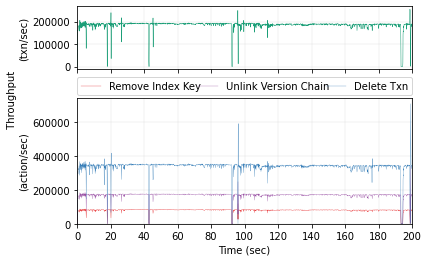

In [20]:
# draw index_remove_key, txn_removal, unlink, and num_txn
# change_font_sizes()
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 2]},)
plt.subplots_adjust(hspace=0.3)

plt.ylabel('Throughput (txn/sec)')

ax1.grid(linestyle='-', linewidth='0.3', color='lightgrey')
ax2.grid(linestyle='-', linewidth='0.3', color='lightgrey')

# y_values = []
# plt.gca().yaxis.set_ticklabels(y_values)

ax1.locator_params(axis='x', nbins=10)
ax2.locator_params(axis='x', nbins=10)

ax2.locator_params(axis='y', nbins=5)

ax2.set_xlabel('Time (sec)')

ax1.set_ylabel('(txn/sec)')
ax2.set_ylabel('(action/sec)')


colors = ['#e41a1c','#377eb8','#984ea3']

ax2.plot( 'start_time', 'INDEX_REMOVE_KEY', data=ave_df, marker='', color=colors[0], linewidth=0.3,  label='Remove Index Key')
ax2.plot( 'start_time', 'UNLINK', data=ave_df, marker='', color=colors[2], linewidth=0.3, label='Unlink Version Chain')
ax2.plot( 'start_time', 'TXN_REMOVAL', data=ave_df, marker='', color=colors[1], linewidth=0.3, label='Delete Txn')

ax1.plot( 'start_time', 'total_num_txns', data=ave_df, marker='', color='#1b9e77', linewidth=0.5)

# ax2.legend(loc='upper right', ncol=3)
# ax1.legend(loc='best', ncol=1)

plt.xlim([xmin, xmax])
# plt.xlim([0, ave_df['start_time'].iloc[-1]])
plt.ylim(ymin=0.0)

ax2.legend(loc='lower left', bbox_to_anchor=(0., 1.02, 1., .102), ncol=3, mode='expand', borderaxespad=0.)


ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_ylabel('          Throughput', labelpad=60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# plt.savefig('../daf_metric_results_folder/per_second_{}daf_{}worker_breakdown.{}'.format(daf_thread_count, worker_thread_count, output_format), format=output_format)
fig.savefig('../metric_figures/per_second_coor_{}worker_breakdown.{}'.format(worker_thread_count, output_format), format=output_format, bbox_inches='tight', dpi=600)
# plt.clf()
print(plt.rcParams["figure.figsize"])

/home/mushroom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


Text(17.200000000000003, 0.5, 'Throughput')

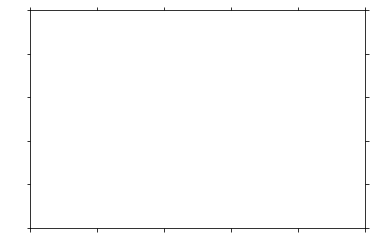

In [8]:
# ax = fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
# ax.set_ylabel('Throughput', labelpad=20)